# Моделювання процесу охолодження залізнорудної агломераційної шихти

## Теоретична частина

### 1. Фізична постановка задачі

Досліджується процес охолодження стандартного шару залізнорудної агломераційної шихти після завершення процесу агломерації. Розглядається поперечний зріз шару з наступними характеристиками:

**Геометричні параметри:**
- Висота шару: 400 мм
- Ширина шару: 2500 мм

**Фізичні параметри:**
- Початкова температура: 400°C (температура після завершення агломерації)
- Кінцева температура: 20°C (температура навколишнього середовища)
- Коефіцієнт температуропровідності: 1×10⁻⁶ м²/с

Коефіцієнт температуропровідності (або коефіцієнт теплопровідності) залізнорудного агломерату залежить від його складу, структури, пористості та інших фізико-хімічних властивостей. Цей коефіцієнт визначає здатність матеріалу проводити тепло і розраховується за формулою:

$$ a = \frac{\lambda}{\rho \cdot c_p} $$

де:
- $a$ — коефіцієнт температуропровідності, [м²/с]
- $\lambda$ — коефіцієнт теплопровідності, [Вт/(м·К)]
- $\rho$ — густина матеріалу, [кг/м³]
- $c_p$ — питома теплоємність, [Дж/(кг·К)]

Для залізнорудного агломерату значення коефіцієнта температуропровідності може коливатися в межах 0,5–1,5·10⁻⁶ м²/с, оскільки агломерат має складну структуру і містить різні компоненти (залізо, оксиди, домішки тощо). Точне значення залежить від конкретного складу та умов вимірювання.

В даній моделі використовується значення $a = 1 \cdot 10^{-6}$ м²/с, що знаходиться в середині діапазону типових значень для залізнорудного агломерату.

### 2. Математична модель

#### 2.1 Рівняння теплопровідності

Процес охолодження описується двовимірним рівнянням теплопровідності Фур'є:

$$ \frac{\partial T}{\partial t} = a \left(\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2}\right) $$

де:
- $T(x,y,t)$ - температура в точці $(x,y)$ в момент часу $t$
- $a$ - коефіцієнт температуропровідності [м²/с]
- $t$ - час [с]
- $x, y$ - просторові координати [м]

#### 2.2 Граничні умови

У задачі використовуються граничні умови першого роду (умови Діріхле):
- На всіх границях підтримується постійна температура навколишнього середовища $T = 20°C$

#### 2.3 Початкові умови

В початковий момент часу температура у всіх точках шару дорівнює температурі після агломерації:
- $T(x,y,0) = 400°C$ для всіх $(x,y)$ всередині області

### 3. Припущення моделі

1. Розглядається двовимірний випадок, оскільки зміни температури в поперечному вимірі (перпендикулярно до зрізу) вважаються незначними
2. Теплообмін відбувається лише з навколишнім середовищем через границі шару
3. Властивості матеріалу (коефіцієнт температуропровідності) вважаються постійними
4. Внутрішні джерела тепла відсутні

## Практична реалізація

### 1. Метод розв'язання

Для розв'язання задачі використовується комбінований підхід:
1. Метод кінцевих різниць для просторової дискретизації
2. Метод Рунге-Кутти 4-5 порядку для інтегрування за часом

#### 1.1 Просторова дискретизація

Використовується рівномірна прямокутна сітка:
- Крок по просторовим координатам: $\Delta x = \Delta y = 0.01$ м
- Кількість точок по ширині: 250
- Кількість точок по висоті: 40

Апроксимація просторових похідних:
$$ \frac{\partial^2 T}{\partial x^2} \approx \frac{T_{i+1,j} - 2T_{i,j} + T_{i-1,j}}{(\Delta x)^2} $$
$$ \frac{\partial^2 T}{\partial y^2} \approx \frac{T_{i,j+1} - 2T_{i,j} + T_{i,j-1}}{(\Delta y)^2} $$

#### 1.2 Часова дискретизація

Для інтегрування за часом використовується адаптивний метод Рунге-Кутти 4-5 порядку (`RK45`), реалізований у функції `solve_ivp` з бібліотеки `scipy.integrate`. Переваги методу:
1. Автоматичний вибір кроку за часом
2. Контроль локальної похибки
3. Висока точність розв'язку
4. Стійкість для жорстких систем

### 2. Особливості реалізації

#### 2.1 Оптимізація обчислень

1. Векторизація обчислень за допомогою NumPy
2. Ефективна робота з масивами без явних циклів
3. Перевикористання масивів для економії пам'яті

#### 2.2 Критерії зупинки

Розрахунок припиняється при виконанні однієї з умов:
1. Досягнення цільової температури (20±1°C) у всіх точках
2. Перевищення максимального часу розрахунку (500000 с ≈ 5.8 діб)

In [3]:
# Імпортуємо необхідні бібліотеки
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

# Визначаємо основні фізичні параметри системи
a = 1e-6   # Коефіцієнт температуропровідності залізнорудного агломерату, м²/с
dx = 0.01  # Крок сітки по x, м (10 мм)
dy = 0.01  # Крок сітки по y, м (10 мм)

def check_temperature(u, target_temp, tolerance=1.0):
    """
    Перевіряє чи досягнута цільова температура у всіх точках шару
    з заданою точністю
    """
    u_reshaped = u.reshape(sizey, sizex)
    return np.all(np.abs(u_reshaped - target_temp) <= tolerance)

def format_time(total_seconds):
    """
    Форматує час із секунд у вигляд "x секунд (y годин)"
    """
    hours = total_seconds / 3600  # Переводимо в години
    return f"{total_seconds:.1f} секунд ({hours:.2f} годин)"

def f_2D_flattened(t, u):
    """
    Допоміжна функція для перетворення двовимірної задачі в одновимірну.
    Розраховує зміну температури в кожній точці шару.
    """
    # Перетворюємо одновимірний масив назад у двовимірний
    u = u.reshape(sizey, sizex)

    # Створюємо масив для похідних
    unew = np.zeros([sizey, sizex])

    # Розраховуємо похідні для всіх внутрішніх точок
    unew[1:-1,1:-1] = (u[2:,1:-1] - 2*u[1:-1,1:-1] + u[:-2,1:-1]) * a/dx**2 + \
                      (u[1:-1,2:] - 2*u[1:-1,1:-1] + u[1:-1,:-2]) * a/dy**2

    # Повертаємо розгорнутий одновимірний масив
    return unew.flatten()

# Визначаємо розміри розрахункової сітки
sizex = 250  # Кількість точок по x (2500 мм / 10 мм)
sizey = 40   # Кількість точок по y (400 мм / 10 мм)

# Задаємо параметри часової еволюції
tStart = 0       # Початковий час, с
time_step = 40   # Крок по часу для перевірки температури, с
max_time = 500000  # Максимальний час розрахунку, с (≈5.8 діб)

# Граничні умови
T_ambient = 20  # Температура навколишнього середовища, °C
T_initial = 400 # Початкова температура шихти після агломерації, °C

# Створення масиву температур та встановлення початкових умов
T = np.zeros([sizey, sizex])
T.fill(T_initial)  # Заповнюємо всі точки початковою температурою

# Встановлюємо граничні умови (температура навколишнього середовища на всіх границях)
T[0,:] = T_ambient    # Нижня границя
T[-1,:] = T_ambient   # Верхня границя
T[:,0] = T_ambient    # Ліва границя
T[:,-1] = T_ambient   # Права границя

print("\nРозрахунок охолодження шару залізнорудної агломераційної шихти...")
print(f"Розмір шару: {sizex*dx*1000:.0f} x {sizey*dy*1000:.0f} мм")
print(f"Кількість точок сітки: {sizex} x {sizey}")
print(f"Початкова температура: {T_initial}°C")
print(f"Температура навколишнього середовища: {T_ambient}°C")

# Ініціалізуємо змінні для зберігання проміжних результатів
current_time = tStart  # Поточний час, с
solutions = []
times = []

while current_time < max_time:
    # Розв'язуємо систему рівнянь на короткому проміжку часу
    solution = integrate.solve_ivp(
        f_2D_flattened,
        [current_time, current_time + time_step],
        T.flatten() if current_time == tStart else solutions[-1].y[:, -1],
        method='RK45',
        vectorized=True
    )
    
    solutions.append(solution)
    times.extend(solution.t)
    
    # Перевіряємо чи досягнута цільова температура
    current_temp = solution.y[:, -1].reshape(sizey, sizex)
    if check_temperature(solution.y[:, -1], T_ambient, tolerance=1.0):
        print(f"\nШар охолонув до температури {T_ambient}±1°C за {format_time(current_time)}")
        break
    
    current_time += time_step
    
    # Виводимо інформацію про прогрес охолодження
    if current_time % 3600 == 0:
        max_temp = np.max(current_temp)
        min_temp = np.min(current_temp)
        avg_temp = np.mean(current_temp)
        print(f"Час: {format_time(current_time)}, "
              f"температура: мін = {min_temp:.1f}°C, "
              f"середня = {avg_temp:.1f}°C, "
              f"макс = {max_temp:.1f}°C")


Розрахунок охолодження шару залізнорудної агломераційної шихти...
Розмір шару: 2500 x 400 мм
Кількість точок сітки: 250 x 40
Початкова температура: 400°C
Температура навколишнього середовища: 20°C
Час: 3600.0 секунд (1.00 годин), температура: мін = 20.0°C, середня = 247.6°C, макс = 383.2°C
Час: 7200.0 секунд (2.00 годин), температура: мін = 20.0°C, середня = 193.4°C, макс = 320.5°C
Час: 10800.0 секунд (3.00 годин), температура: мін = 20.0°C, середня = 154.4°C, макс = 259.5°C
Час: 14400.0 секунд (4.00 годин), температура: мін = 20.0°C, середня = 124.7°C, макс = 209.9°C
Час: 18000.0 секунд (5.00 годин), температура: мін = 20.0°C, середня = 101.7°C, макс = 170.4°C
Час: 21600.0 секунд (6.00 годин), температура: мін = 20.0°C, середня = 83.8°C, макс = 139.0°C
Час: 25200.0 секунд (7.00 годин), температура: мін = 20.0°C, середня = 69.9°C, макс = 114.3°C
Час: 28800.0 секунд (8.00 годин), температура: мін = 20.0°C, середня = 59.1°C, макс = 94.6°C
Час: 32400.0 секунд (9.00 годин), температура: м

#### 2.3 Візуалізація результатів

Результати представляються у вигляді:
1. Контурних графіків розподілу температури для ключових моментів часу:
   - Початковий стан
   - 1/3 загального часу
   - 2/3 загального часу
   - Кінцевий стан
2. Текстових повідомлень про:
   - Поточну мінімальну, середню та максимальну температуру
   - Загальний час охолодження

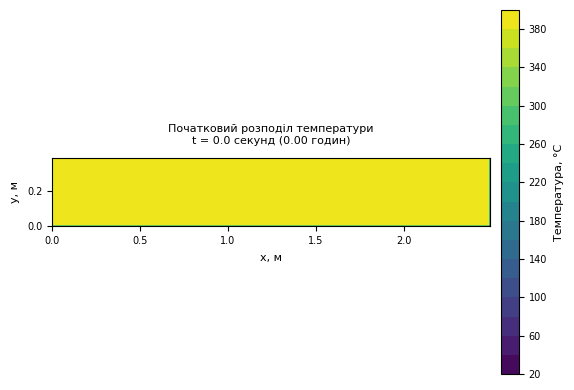

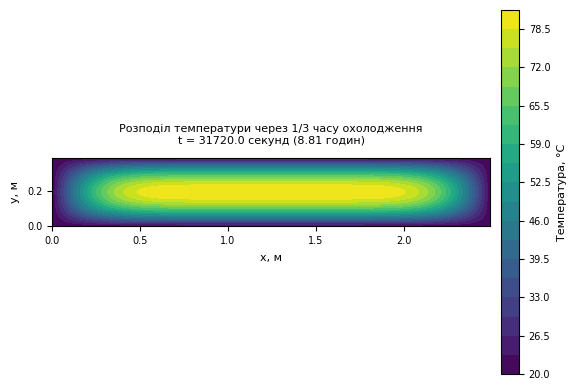

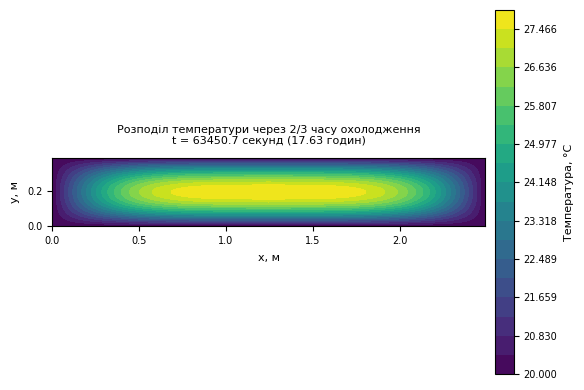

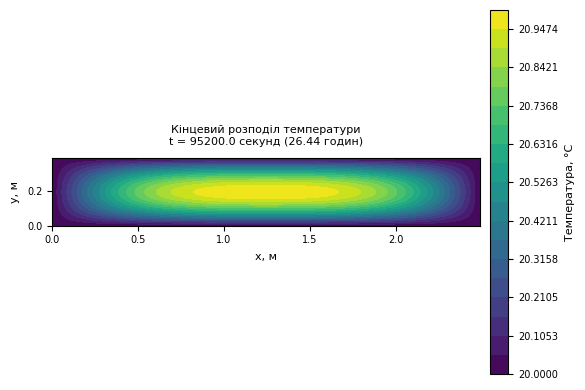

In [9]:
# Об'єднуємо всі розв'язки для візуалізації
all_times = np.array(times)
all_solutions = np.hstack([sol.y for sol in solutions])

# Створюємо сітку для візуалізації
x_list, y_list = np.meshgrid(np.arange(sizex)*dx, np.arange(sizey)*dy)

# Візуалізуємо результати для різних моментів часу
viz_indices = [0,                    # Початок
               len(all_times) // 3,  # 1/3 часу
               2 * len(all_times) // 3,  # 2/3 часу
               -1]                   # Кінець

# Створюємо окремий графік для кожного моменту часу
titles = ['Початковий розподіл температури',
          'Розподіл температури через 1/3 часу охолодження',
          'Розподіл температури через 2/3 часу охолодження',
          'Кінцевий розподіл температури']

for idx, plot_idx in enumerate(viz_indices):
    plt.figure(figsize=(6, 4))
    plt.title(f'{titles[idx]}\nt = {format_time(all_times[plot_idx])}', 
              pad=10, fontsize=8)
    plt.xlabel('x, м', labelpad=5, fontsize=8)
    plt.ylabel('y, м', labelpad=5, fontsize=8)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    
    # Встановлюємо фіксований діапазон температур для кожного графіка
    if idx == 0:  # Перший графік (початковий стан)
        vmin, vmax = T_ambient, T_initial
    else:  # Інші графіки
        vmin, vmax = T_ambient, max(np.max(all_solutions[:, plot_idx]), T_ambient + 1)
    
    temp = plt.contourf(x_list, y_list, 
                       all_solutions[:, plot_idx].reshape(sizey, sizex),
                       levels=np.linspace(vmin, vmax, 20),
                       vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(temp, label='Температура, °C', pad=0.02)
    cbar.ax.tick_labels = [f'{x:.0f}' for x in cbar.get_ticks()]
    cbar.ax.tick_params(labelsize=7)
    cbar.ax.set_ylabel('Температура, °C', fontsize=8, labelpad=5)
    
    # Встановлюємо однакові пропорції для осей
    plt.gca().set_aspect('equal', adjustable='box')
    
    # Додаємо відступи
    plt.tight_layout()
    plt.show()

### 3. Висновки та рекомендації

1. Час охолодження значно залежить від розмірів шару та коефіцієнта температуропровідності
2. Охолодження відбувається нерівномірно:
   - Краї охолоджуються швидше через прямий контакт з навколишнім середовищем
   - Центральна частина охолоджується повільніше через необхідність відведення тепла через сусідні шари
3. Для прискорення охолодження можна рекомендувати:
   - Зменшення товщини шару
   - Забезпечення кращого теплообміну з навколишнім середовищем
   - Використання примусового охолодження